# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

Постройте модель, которая по фотографии определит приблизительный возраст человека. В вашем распоряжении набор фотографий людей с указанием возраста.


## Исследовательский анализ данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd

from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
datagen = ImageDataGenerator(validation_split=0.25, rescale = 1.0/255)

labels = pd.read_csv('/datasets/faces/labels.csv')
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Всего 7591 строка без пропусков.

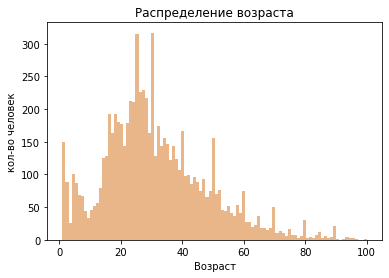

In [ ]:
labels['real_age'].plot(kind = 'hist', bins =100, color = '#e9b68a',
                        title = 'Распределение возраста');
plt.xlabel('Возраст');
plt.ylabel('кол-во человек');

Видно небольшое кол-во выбросов в самом начале и длинный хвост с левой стороны.

Found 5694 validated image filenames.


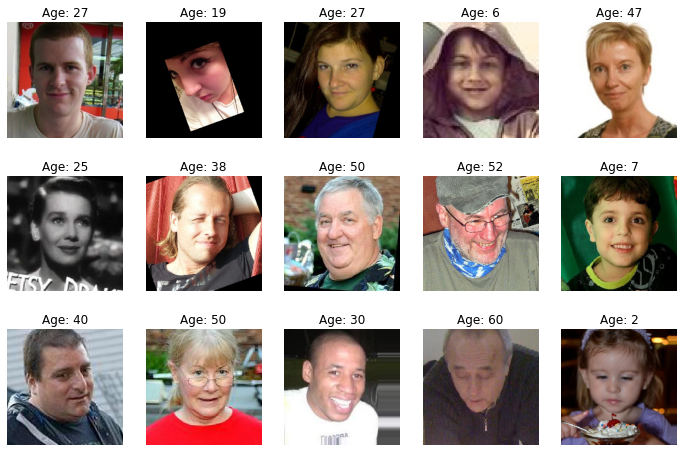

In [ ]:
train_datagen = datagen.flow_from_dataframe(directory = '/datasets/faces/final_files/',
                                           target_size = (224,224),
                                           batch_size = 15,
                                           class_mode ='raw',
                                           subset = 'training',
                                           seed = 12345,
                                           dataframe = labels,
                                           x_col ='file_name',
                                           y_col ='real_age')

images, labels = train_datagen.next()
plt.figure(figsize = (12, 8))
for i in range(len(images)):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i])
    plt.title(f"Age: {labels[i]}")
    plt.axis('off')
plt.show()

Исходные данные понятны.

- Наш датасет состоит из 7591 строки.
- Распределение возраста варьируется от 0 до 100 лет. Распределение близко к нормальному.
- На некоторых фотографиях видны не только лица, но и другие предметы, которые по-хорошему нужно обрезать.
- Для этого можно использовать кроп.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

labels = pd.read_csv('/datasets/faces/labels.csv')

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow
def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet',
                    include_top=False) #,  pooling = 'avg'
    model = Sequential()
    backbone.trainable = True
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    #model.add(Flatten())
    #model.add(Dense(512, activation='relu'))
    #model.add(Dropout(.5))
    #model.add(Dropout(.3))
    #model.add(Dense(256, activation='relu'))
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=5,
                steps_per_epoch=None, validation_steps=None):
    model.summary()
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model


```

```
Train for 356 steps, validate for 119 steps
Epoch 1/5
2024-04-09 10:42:19.323508: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-04-09 10:42:19.725283: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 55s - loss: 10.7213 - mae: 10.7221 - val_loss: 20.3900 - val_mae: 20.3838
Epoch 2/5
356/356 - 45s - loss: 7.3947 - mae: 7.3945 - val_loss: 9.8256 - val_mae: 9.8219
Epoch 3/5
356/356 - 44s - loss: 6.5886 - mae: 6.5891 - val_loss: 7.4936 - val_mae: 7.4905
Epoch 4/5
356/356 - 60s - loss: 5.8923 - mae: 5.8933 - val_loss: 6.8259 - val_mae: 6.8293
Epoch 5/5
356/356 - 54s - loss: 5.4103 - mae: 5.4105 - val_loss: 6.9107 - val_mae: 6.9130
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 6.9107 - mae: 6.9130
Test MAE: 6.9130


```

## Анализ обученной модели

- Для данной задачи использовалась модель ResNet50. Это модель уже обученная на какие-то веса, и она очень неплохо справилась с решением.
- Для сети был добавлен слой ResNet, слой пулинга и выходной с активацией relu и 1 нейроном на выходе. 6 эпох. Оптимизатор Adam с lr = 0.00001.
- Тренировочные изображения были агументированы горизонтальным отражением.
- На последнем слое модель начала чуть переобучаться. Итоговая метрика: 6.91 на тестовой выборке.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы